### Step 1: Read and Preprocess Data  

#### 1. Initial Attempt with Hugging Face Library
Initially, I planned to use the Hugging Face library to download and preprocess the dataset directly. However, this approach proved to be:
- **Drastically slow**, making experimentation inefficient.
- **Inconvenient** due to library-specific constraints on data manipulation.

To address these issues, I decided to download a smaller, **-mini** version of the dataset locally and process it with familiar tools (e.g., Pandas).

---

#### 2. Machine Limitations and Sampling Strategy
Upon attempting to load the dataset, I realized that:
- My machine lacked sufficient memory and computational power to handle the dataset in its entirety.
- Even a significant portion of the data was too large to process efficiently.

### Solution:
I opted to **sample the dataset**, selecting only a subset of records for each `client_id`. This sampling strategy ensures:
- The sample remains **representative** of the full dataset.
- The sample size is **manageable**, enabling faster experimentation and analysis.


In [2]:
# Define paths to data:
DIALOG_PATH = "../ml/detail/dialog"
GEO_PATH = "../ml/detail/geo"
TRX_PATH = "../ml/detail/trx"
TARGET_PATH = "../ml/targets"

In [3]:
import pandas as pd
import os

dialog_list = []
geo_list = []
trx_list = []

# Loop through all the folds (0 to 4)
for FOLD in range(5):
    # Read and sample 10 records for each `client_id` from each fold
    dialog_fold = pd.read_parquet(os.path.join(DIALOG_PATH, f'fold={FOLD}')).groupby('client_id').head(10)
    geo_fold = pd.read_parquet(os.path.join(GEO_PATH, f'fold={FOLD}')).groupby('client_id').head(10)
    trx_fold = pd.read_parquet(os.path.join(TRX_PATH, f'fold={FOLD}')).groupby(['client_id', 'event_type']).head(10)
    trx_fold['fold'] = FOLD
    
    # Append the data from each fold to the respective list
    dialog_list.append(dialog_fold)
    geo_list.append(geo_fold)
    trx_list.append(trx_fold)

# Concatenate all folds into a single dataframe for each type
dialog = pd.concat(dialog_list, ignore_index=True)
geo = pd.concat(geo_list, ignore_index=True)
trx = pd.concat(trx_list, ignore_index=True)

print(dialog.shape)
print(geo.shape)
print(trx.shape)

(182832, 3)
(704144, 5)
(4527234, 15)


In [4]:
# Notice that the number of clients is not the same in these dataframes
print(f"Number of unique clients in trx: {trx['client_id'].nunique()}")
print(f"Number of unique clients in dialog: {dialog['client_id'].nunique()}")
print(f"Number of unique clients in geo: {geo['client_id'].nunique()}")

# Filter to ensure consistency
trx = trx[trx['client_id'].isin(dialog['client_id'])]
geo = geo[geo['client_id'].isin(dialog['client_id'])]

Number of unique clients in trx: 98721
Number of unique clients in dialog: 46320
Number of unique clients in geo: 72573


In [5]:
dialog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182832 entries, 0 to 182831
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   182832 non-null  object        
 1   event_time  182832 non-null  datetime64[ns]
 2   embedding   182832 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 4.2+ MB


In [6]:
geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346382 entries, 0 to 704113
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   346382 non-null  object        
 1   event_time  346382 non-null  datetime64[ns]
 2   geohash_4   346382 non-null  int32         
 3   geohash_5   346382 non-null  int32         
 4   geohash_6   346382 non-null  int32         
dtypes: datetime64[ns](1), int32(3), object(1)
memory usage: 11.9+ MB


In [7]:
trx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3001665 entries, 19 to 4527233
Data columns (total 15 columns):
 #   Column         Dtype         
---  ------         -----         
 0   client_id      object        
 1   event_time     datetime64[ns]
 2   amount         float32       
 3   event_type     int32         
 4   event_subtype  int32         
 5   currency       float64       
 6   src_type11     float64       
 7   src_type12     float64       
 8   dst_type11     float64       
 9   dst_type12     float64       
 10  src_type21     float64       
 11  src_type22     float64       
 12  src_type31     float64       
 13  src_type32     float64       
 14  fold           int64         
dtypes: datetime64[ns](1), float32(1), float64(9), int32(2), int64(1), object(1)
memory usage: 332.1+ MB


### Step 2: Visualize Data

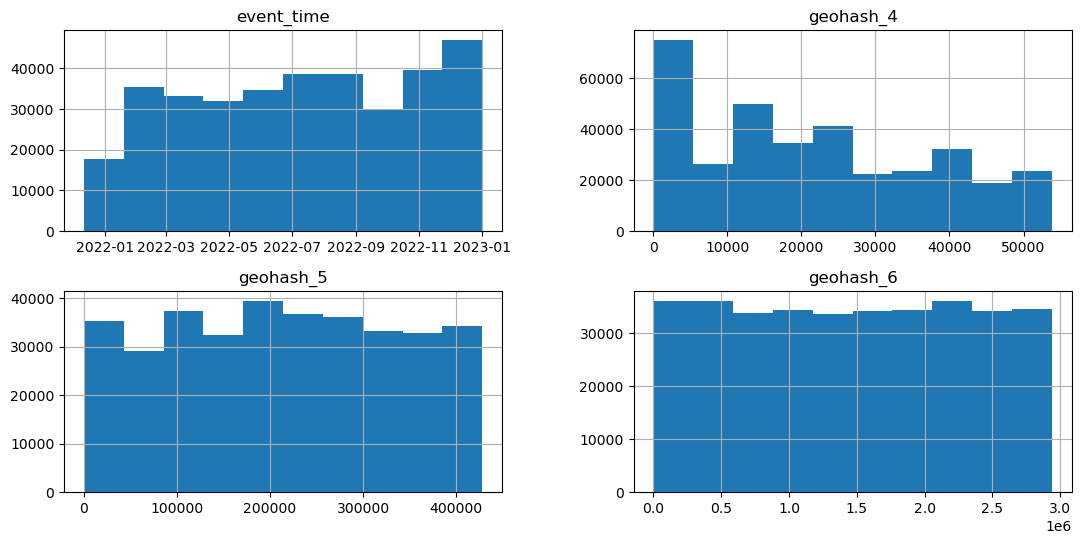

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (13, 6)
geo.hist();

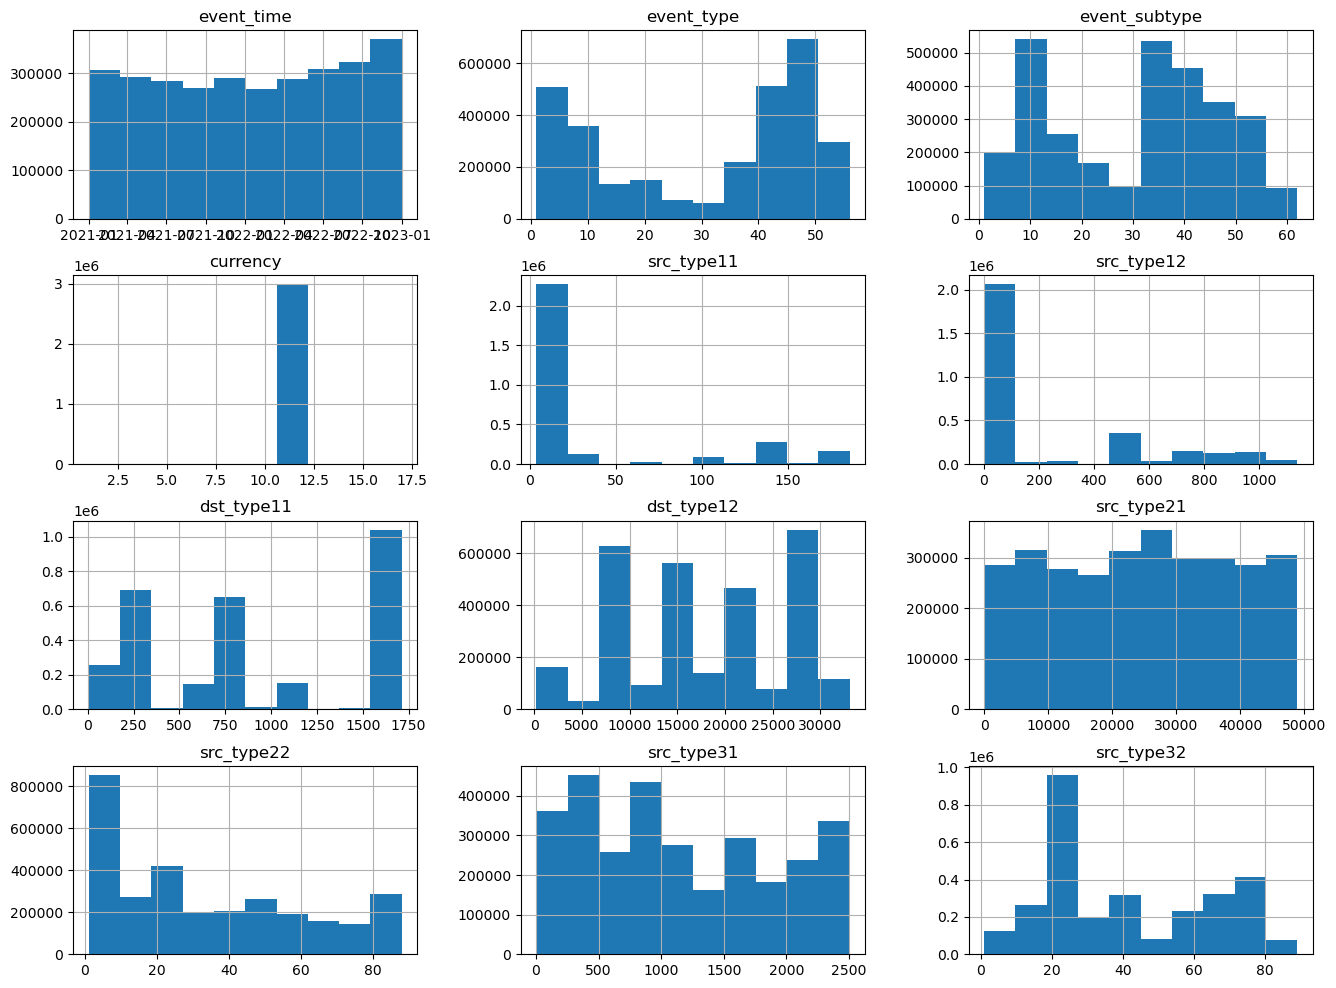

In [9]:
plt.rcParams['figure.figsize'] = (16, 12)
trx.drop(columns=['amount', 'fold']).hist();

**Brief conclusion**: most of the features are neither uniformly nor normally distributed.

### Step 3: Feature Engineering

In [10]:
import numpy as np

# Group transactions by month
trx['month'] = trx['event_time'].dt.to_period('M')
geo['month'] = geo['event_time'].dt.to_period('M')
dialog['month'] = dialog['event_time'].dt.to_period('M')

def mode(x):
    return x.mode().iloc[0] if not x.mode().empty else None

dialog_features = dialog.groupby(['client_id', 'month'])['embedding'].apply(np.mean).apply(np.mean).reset_index()

# Count unique geohashes and calculate movement diversity.
geo_features = geo.groupby(['client_id', 'month']).agg({
    'geohash_4': 'nunique',
    'geohash_5': 'nunique',
    'geohash_6': 'nunique'
}).reset_index()

trx_features = trx.groupby(['client_id', 'month']).agg({
    'event_type': 'nunique',
    'currency': 'nunique',
    'amount': 'sum',
    'dst_type11': 'nunique',
    'dst_type12': 'nunique',
    'src_type21': 'nunique',
    'src_type31': 'nunique',
}).reset_index()

trx_features.head()


,client_id,month,event_type,currency,amount,dst_type11,dst_type12,src_type21,src_type31
0,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2021-11,1,1,737.651062,1,1,1,1
1,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2021-12,1,1,1.356884,1,1,1,1
2,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-01,1,1,181.289734,1,1,1,1
3,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-02,4,1,27357.484375,3,4,1,1
4,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-03,1,1,3668.287354,1,1,1,1


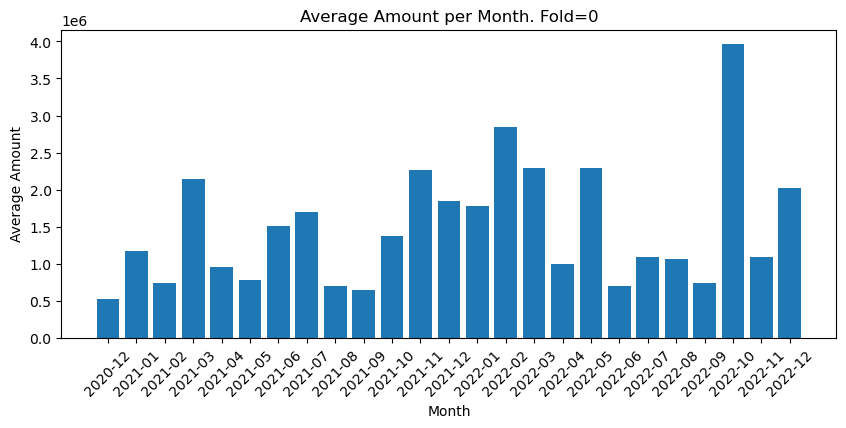

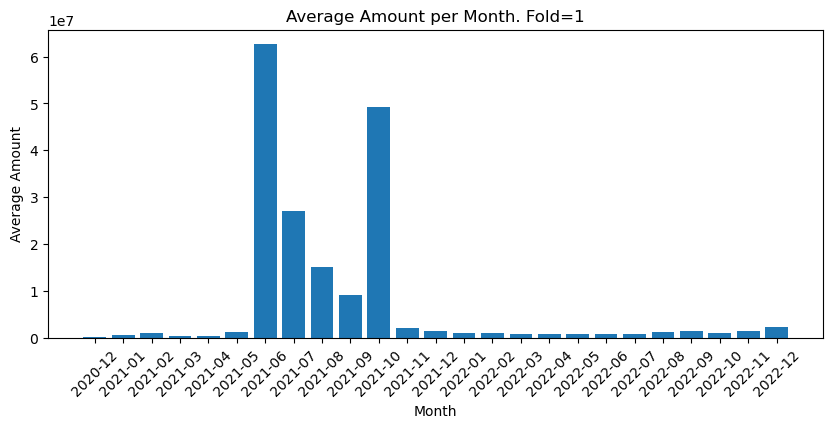

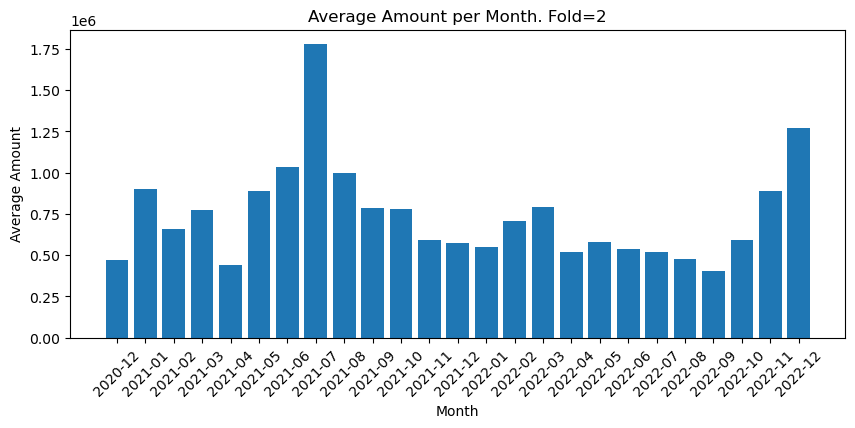

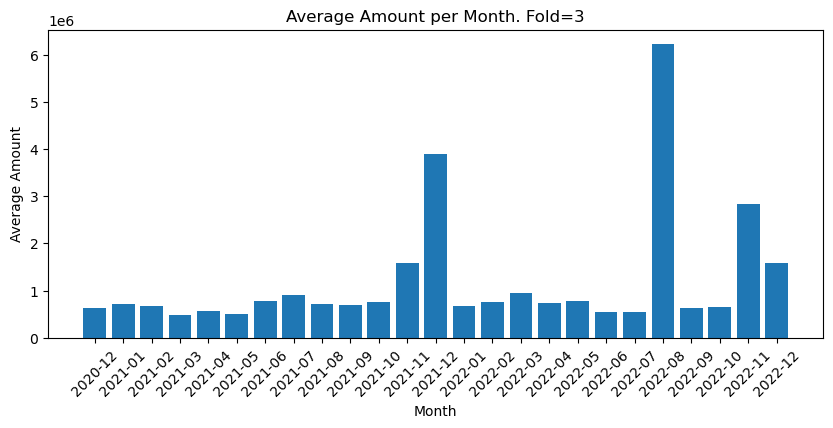

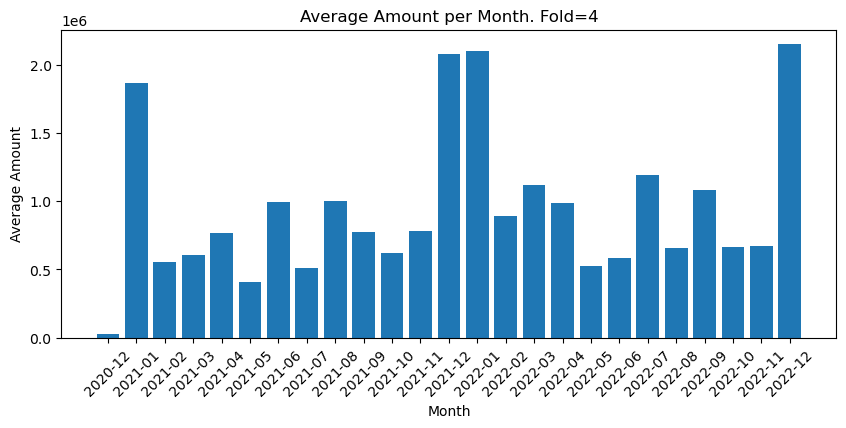

In [11]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 4)

for FOLD in range(5):
    # Filter the data for the current fold
    # Grouping by 'month' and calculating the average 'amount'
    monthly_avg_amount = trx[trx['fold'] == FOLD].groupby('month')['amount'].mean()

    # Create a new figure for each fold
    plt.figure()

    # Plotting the bar plot
    plt.bar(monthly_avg_amount.index.astype(str), monthly_avg_amount.values)
    plt.xlabel('Month')
    plt.ylabel('Average Amount')
    plt.title(f'Average Amount per Month. Fold={FOLD}')
    plt.xticks(rotation=45)
    plt.show()

**Note**: Seasonal trend is present in the 4th fold only. Statistics is very inconsistent across other folds.

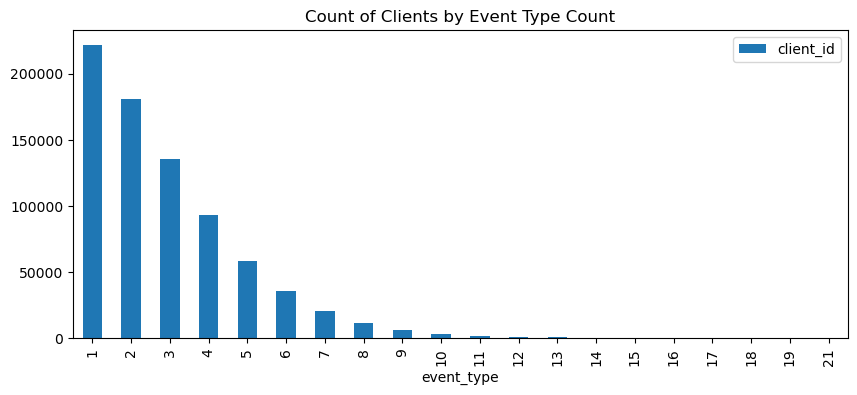

In [12]:
grouped = trx_features.groupby('event_type').agg({'client_id': 'count'})
grouped.plot(kind='bar', y='client_id', title='Count of Clients by Event Type Count');

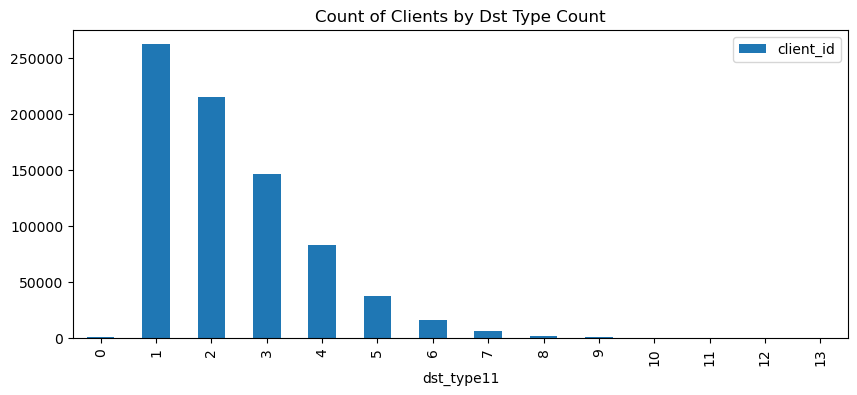

In [13]:
grouped = trx_features.groupby('dst_type11').agg({'client_id': 'count'})
grouped.plot(kind='bar', y='client_id', title='Count of Clients by Dst Type Count');

### **Define Objective**: To predict for each user the taking/not taking of each of the four products within a month after the reporting date, historical data for them is in targets.
Equivalent to a multi-label classification problem:  
- **Input Features:**
  - Historical transactions
  - Dialog embeddings
  - Geographic activity
- **Output Labels:**  
  For each client *i* at time *t*, predict y(*i*,*t*), indicating the presence (1) or absence (0) of product *k*.

<u>Mathematical formulation</u>:
y(*i*,*t*) = f(X(*i*,*t-1*), ..., X(*i*,*t-N*)),
where *f* is the predictive function, X(*i*,*t*) represents the client features (transactions, embeddings, geo-activity) at time *t*, and *N* is the historical window size.

In [14]:
import pandas as pd
import os

# Initialize an empty list to store DataFrames
all_targets = []

# Loop through each fold (0 to 4)
for FOLD in range(5):
    # Read the parquet file for each fold
    targets = pd.read_parquet(os.path.join(TARGET_PATH, f'fold={FOLD}'))
    
    # Filter targets to keep only the rows where at least one of the target columns is 1
    targets = targets[targets[['target_1', 'target_2', 'target_3', 'target_4']].eq(1).any(axis=1)]
    
    # Rename the 'mon' column to 'month'
    targets.rename(columns={'mon': 'month'}, inplace=True)
    
    # Convert 'month' to datetime and then to period (monthly) format
    targets['month'] = pd.to_datetime(targets['month']).dt.to_period('M')

    targets['fold'] = FOLD
    
    # Append the current fold's DataFrame to the list
    all_targets.append(targets)

# Concatenate all the DataFrames into a single DataFrame
targets = pd.concat(all_targets, ignore_index=True)

# Check the result
targets.head()


,client_id,month,target_1,target_2,target_3,target_4,trans_count,diff_trans_date,fold
0,0af35089e0209afc40991bebc9938f045cf2b549a0c49d...,2022-06,1,0,0,1,0,NaN,0
1,18e7bb6c310d0ee7aa5ac0bc30332f9d024445b0938a78...,2022-11,0,0,0,1,0,NaN,0
2,18e7bb6c310d0ee7aa5ac0bc30332f9d024445b0938a78...,2023-01,0,0,1,0,12,5.0,0
3,1ec4457a99c85b7e7ee176913c5b8af15545728e76fedf...,2022-07,1,0,0,0,0,NaN,0
4,247f277dea55b00664fa74864921864c8c14fd33f15c97...,2022-08,1,0,0,0,80,13.0,0


In [15]:
targets.describe()

,target_1,target_2,target_3,target_4,trans_count,diff_trans_date,fold
count,12854.000000,12854.000000,12854.000000,12854.000000,12854.000000,11153.000000,12854.000000
mean,0.417146,0.044889,0.352419,0.238058,137.907422,5.578140,1.993154
std,0.493107,0.207068,0.477742,0.425911,177.769250,18.544012,1.417384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,67.000000,1.000000,2.000000
75%,1.000000,0.000000,1.000000,0.000000,194.000000,4.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,997.000000,355.000000,4.000000


### Step 4: Compose the final dataframe

In [23]:
# Merge features
merged_data = dialog_features.merge(geo_features, on=['client_id', 'month'], how='left')
merged_data = merged_data.merge(trx_features, on=['client_id', 'month'], how='left')

# Add target labels
final_data = merged_data.merge(targets, on=['client_id', 'month'], how='inner')

In [24]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   client_id        4172 non-null   object   
 1   month            4172 non-null   period[M]
 2   embedding        4172 non-null   float32  
 3   geohash_4        1253 non-null   float64  
 4   geohash_5        1253 non-null   float64  
 5   geohash_6        1253 non-null   float64  
 6   event_type       3466 non-null   float64  
 7   currency         3466 non-null   float64  
 8   amount           3466 non-null   float32  
 9   dst_type11       3466 non-null   float64  
 10  dst_type12       3466 non-null   float64  
 11  src_type21       3466 non-null   float64  
 12  src_type31       3466 non-null   float64  
 13  target_1         4172 non-null   int32    
 14  target_2         4172 non-null   int32    
 15  target_3         4172 non-null   int32    
 16  target_4         4172 no

In [25]:
def fill_missing_values(df):
    # Numerical columns
    numerical_cols = ['amount', 'event_type', 'diff_trans_date', 'dst_type11',
                      'dst_type12', 'src_type21', 'src_type31', 'currency']
    df[numerical_cols] = df[numerical_cols].fillna(0)  # Replace NaNs with 0 for sums/counts

    # Geographic columns
    geo_cols = ['geohash_4', 'geohash_5', 'geohash_6']
    df[geo_cols] = df[geo_cols].fillna(0)  # Assume no geohashes for missing data
    
    return df

# Apply the fill function to trx_features
final_data = fill_missing_values(final_data)

# Verify the result
print(final_data.isnull().sum())  # Ensure no missing values remain

client_id          0
month              0
embedding          0
geohash_4          0
geohash_5          0
geohash_6          0
event_type         0
currency           0
amount             0
dst_type11         0
dst_type12         0
src_type21         0
src_type31         0
target_1           0
target_2           0
target_3           0
target_4           0
trans_count        0
diff_trans_date    0
fold               0
dtype: int64


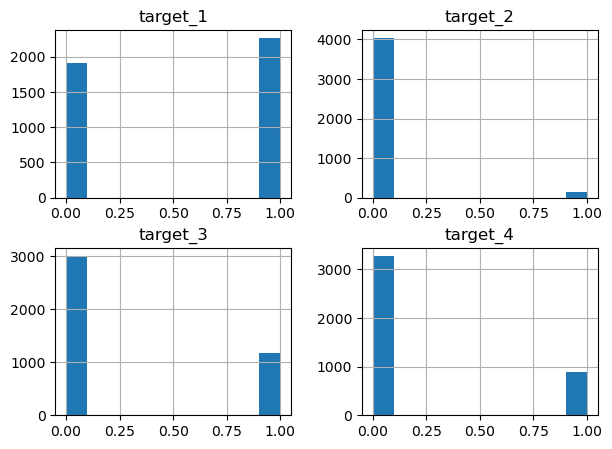

In [32]:
# Targets are crucially unbalanced
plt.rcParams['figure.figsize'] = (7, 5)
final_data[['target_1', 'target_2', 'target_3', 'target_4']].hist();

In [33]:
# Select features and targets
features = ['event_type', 'currency', 'dst_type11',
            'amount', 'diff_trans_date',
            'geohash_4', 'geohash_5', 'geohash_6', 'embedding',
            'dst_type12', 'src_type21', 'src_type31']
targets = ['target_1', 'target_2', 'target_3', 'target_4']

# Split into X and Y
X = final_data[features]
Y = final_data[targets]

In [34]:
# Weak correlation with targets. In general, more advanced preprocessing is needed.
corr_matrix = final_data[features + targets].corr()
corr_with_targets = corr_matrix[['target_1', 'target_2', 'target_3', 'target_4']]
print(corr_with_targets)

                 target_1  target_2  target_3  target_4
event_type      -0.196738  0.165131  0.224476 -0.071669
currency        -0.181726  0.056730  0.189616 -0.008252
dst_type11      -0.183311  0.137317  0.209463 -0.051042
amount           0.011697  0.011730  0.032931 -0.016588
diff_trans_date  0.054863 -0.000447 -0.044088 -0.020769
geohash_4       -0.010453  0.033211  0.001788 -0.005327
geohash_5       -0.003574  0.024606 -0.006820 -0.001951
geohash_6       -0.003643  0.023435 -0.003331 -0.006620
embedding       -0.012595  0.018987 -0.010807  0.013455
dst_type12      -0.179152  0.147691  0.205503 -0.058797
src_type21      -0.185382  0.056690  0.189842 -0.003292
src_type31      -0.185382  0.056690  0.191263 -0.004847
target_1         1.000000 -0.159463 -0.556122 -0.434752
target_2        -0.159463  1.000000 -0.084817 -0.056235
target_3        -0.556122 -0.084817  1.000000 -0.272964
target_4        -0.434752 -0.056235 -0.272964  1.000000


### First, let's try to use all the data at once.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize multi-output classifier
multi_rf = MultiOutputClassifier(RandomForestClassifier(random_state=42, n_jobs=-1))

# Fit the model
multi_rf.fit(X_train, Y_train)

# Predict on test data
Y_pred = multi_rf.predict(X_test)

In [36]:
# Evaluate performance
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(Y_test, Y_pred, target_names=targets, zero_division=np.nan))
print(f"accuracy_score: {accuracy_score(Y_test, Y_pred)}")

              precision    recall  f1-score   support

    target_1       0.59      0.56      0.57       450
    target_2       0.00      0.00      0.00        26
    target_3       0.35      0.18      0.24       224
    target_4       0.24      0.07      0.11       200

   micro avg       0.50      0.34      0.41       900
   macro avg       0.29      0.20      0.23       900
weighted avg       0.43      0.34      0.37       900
 samples avg       0.50      0.34      0.34       900

accuracy_score: 0.2994011976047904


### Now, let's split into folds for cross-validation.

In [37]:
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize MultiOutputClassifier with RandomForestClassifier
multi_rf = MultiOutputClassifier(RandomForestClassifier(random_state=42, n_jobs=-1))

# Initialize GroupKFold cross-validation with 5 splits (based on the 'fold' column)
group_kfold = GroupKFold(n_splits=5)

# Initialize a list to store scores (e.g., accuracy)
scores = []
i = 0
# Cross-validation loop
for train_index, test_index in group_kfold.split(X, Y, groups=final_data['fold']):
    i += 1
    # Split the data into train and test based on the indices
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Fit the model
    multi_rf.fit(X_train, Y_train)
    
    # Predict on test data
    Y_pred = multi_rf.predict(X_test)
    
    # Calculate metrics
    print(f"Split #{i}")
    print(classification_report(Y_test, Y_pred, target_names=targets, zero_division=np.nan))
    print(f"accuracy_score: {accuracy_score(Y_test, Y_pred)}")
    print('==========================\n')

Split #1
              precision    recall  f1-score   support

    target_1       0.57      0.55      0.56       473
    target_2       0.00      0.00      0.00        35
    target_3       0.34      0.16      0.22       252
    target_4       0.19      0.06      0.09       195

   micro avg       0.50      0.33      0.39       955
   macro avg       0.28      0.19      0.22       955
weighted avg       0.41      0.33      0.35       955
 samples avg       0.50      0.33      0.33       955

accuracy_score: 0.29654403567447046

Split #2
              precision    recall  f1-score   support

    target_1       0.60      0.56      0.58       461
    target_2       0.00      0.00      0.00        32
    target_3       0.30      0.18      0.22       223
    target_4       0.25      0.07      0.10       198

   micro avg       0.51      0.34      0.41       914
   macro avg       0.29      0.20      0.23       914
weighted avg       0.43      0.34      0.37       914
 samples avg       0.5

In [38]:
# Extract feature importance from each estimator
feature_importances = np.mean(
    [est.feature_importances_ for est in multi_rf.estimators_], axis=0)

# Map to feature names
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(importance_df)

            Feature  Importance
8         embedding    0.347358
3            amount    0.290607
4   diff_trans_date    0.115989
0        event_type    0.080837
9        dst_type12    0.053893
2        dst_type11    0.050652
7         geohash_6    0.018928
6         geohash_5    0.017121
5         geohash_4    0.014892
1          currency    0.004301
11       src_type31    0.002920
10       src_type21    0.002502


#### Let's try to improve metrics using **xgboost**:

In [39]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Split the data
X = final_data.drop(columns=['client_id', 'month', 'target_1', 'target_2', 'target_3', 'target_4'], errors='ignore')
y = final_data[['target_1', 'target_2', 'target_3', 'target_4']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train separate models for each target
models = {}
for target in y.columns:
    print(f"Training model for {target}...")
    model = XGBClassifier(random_state=42, eval_metric='logloss')
    model.fit(X_train, y_train[target])
    models[target] = model

# Step 3: Evaluate each model
for target in y.columns:
    print(f"\nEvaluating model for {target}...")
    y_pred = models[target].predict(X_test)
    print(f"Classification Report for {target}:")
    print(classification_report(y_test[target], y_pred, zero_division=np.nan))
    print(f"accuracy_score: {accuracy_score(y_test[target], y_pred)}")
    print("==================================")

Training model for target_1...
Training model for target_2...
Training model for target_3...
Training model for target_4...

Evaluating model for target_1...
Classification Report for target_1:
              precision    recall  f1-score   support

           0       0.57      0.52      0.54       385
           1       0.62      0.66      0.64       450

    accuracy                           0.60       835
   macro avg       0.59      0.59      0.59       835
weighted avg       0.59      0.60      0.59       835

accuracy_score: 0.5952095808383233

Evaluating model for target_2...
Classification Report for target_2:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       809
           1       0.09      0.04      0.05        26

    accuracy                           0.96       835
   macro avg       0.53      0.51      0.52       835
weighted avg       0.94      0.96      0.95       835

accuracy_score: 0.9580838323353293

Evaluating 

In [40]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [41]:
# Best Score
print("Best F1 Score:", grid_search.best_score_)

Best F1 Score: 0.2848558107705013
